# Check accuracy

In [1]:
import sys
import random

import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

#torch
import torch
from torch import nn
import torch.nn.functional as F
from torch.optim import Adam
from torchvision.utils import save_image
import torchvision.utils as vutils

from p3.model import DANN
from p3.dataset import P3TestDataset, P3Dataset, get_transform

# Set random seed for reproducibility
SEED = 5566
#manualSeed = random.randint(1, 10000) # use if you want new results
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
random.seed(SEED)
device = "cuda" if torch.cuda.is_available() else "cpu"

/home/guest/r11922a05/anaconda3/envs/dlcv-hw2/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# svhn
pred_df = pd.read_csv("test_pred_svhn.csv")
pred_label = pred_df["label"]

gt_df = pd.read_csv("./hw2_data/digits/svhn/val.csv")
gt_label = gt_df["label"]

n_img = pred_df.shape[0] #15887
n_correct = sum(pred_label == gt_label) 
acc = n_correct / n_img
print(f"Acc: {acc}")
# should be > 40

Acc: 0.4331843645748096


In [3]:
# usps
pred_df = pd.read_csv("test_pred_usps.csv")
pred_label = pred_df["label"]

gt_df = pd.read_csv("./hw2_data/digits/usps/val.csv")
gt_label = gt_df["label"]

n_img = pred_df.shape[0] #1488
n_correct = sum(pred_label == gt_label) 
acc = n_correct / n_img 
print(f"Acc: {acc}")
# should be > 76

Acc: 0.7741935483870968


# Visualize latent space
- steps
    - load source and target **validation** data
    - load source and **ground truth label**
    - create **domain label**
    - visualize by GT label and domain label

In [2]:
mnistm_dir = "./hw2_data/digits/mnistm/data/val/"
svhn_dir = "./hw2_data/digits/svhn/data/val/"
usps_dir = "./hw2_data/digits/usps/data/val/"

class Args:
    def __init__(self):
        self.image_size = 28
        self.channels = 3
        self.batch_size = 128
        self.use_dann = 1
        self.get_feat = 1

In [3]:
args = Args()
transform = get_transform(args)
mnistm_df = pd.read_csv("./hw2_data/digits/mnistm/val.csv")
svhn_df = pd.read_csv("./hw2_data/digits/svhn/val.csv")
usps_df = pd.read_csv("./hw2_data/digits/usps/val.csv")

mnistm_label = mnistm_df["label"].tolist()
svhn_label = svhn_df["label"].tolist()
usps_label = usps_df["label"].tolist()

mnistm_ds = P3Dataset(mnistm_dir, mnistm_label, transform=transform)
svhn_ds = P3Dataset(svhn_dir, svhn_label, transform=transform)
usps_ds = P3Dataset(usps_dir, usps_label, transform=transform)

mnistm_dl = torch.utils.data.DataLoader(mnistm_ds,batch_size=args.batch_size,shuffle=False)
svhn_dl = torch.utils.data.DataLoader(svhn_ds,batch_size=args.batch_size,shuffle=False)
usps_dl = torch.utils.data.DataLoader(usps_ds,batch_size=args.batch_size,shuffle=False)

In [9]:
def get_feat_n_label(model, dl):
    model.eval()
    lam = 0 #we don't need to compute domain clf in eval
    i = 0
    with torch.no_grad():
        for img, label in dl:
            img = img.to(device)
            feat, class_out = model(img, lam)
            feat = feat.detach().cpu().numpy()
            #pred = torch.max(class_out, axis=1)[1].detach().cpu().numpy()
            # label = label
            if i == 0:
                feat_all = feat
                pred_all = label
            else:
                feat_all = np.concatenate([feat_all, feat], axis=0)
                pred_all = np.concatenate([pred_all, label], axis=0)
            i += 1
    return feat_all, pred_all

In [6]:
def tsne_by_label(features, labels):
    X_tsne = TSNE(n_components=2, init='pca', random_state=SEED).fit_transform(features)
    #print('X_tsne', X_tsne.shape)
    
    #TSNE Visualization
    x_min = X_tsne.min()
    x_max = X_tsne.max()
    X_norm = (X_tsne - x_min) / (x_max - x_min)  #Normalize
    #print('X_norm', X_norm.shape)

    plt.figure(figsize=(8, 8))
    for i in range(X_norm.shape[0]):
        plt.text(
            X_norm[i, 0], X_norm[i, 1], 
            str(labels[i]), color=plt.cm.Set1(labels[i]), 
            fontdict={'weight': 'bold', 'size': 9}
            )

    plt.xticks([])
    plt.yticks([])
    plt.show()
    
    return X_norm

In [7]:
def tsne_by_domain(X_norm, labels):
    plt.figure(figsize=(20, 20))
    for i in range(X_norm.shape[0]):
        plt.text(X_norm[i, 0], X_norm[i, 1], str(labels[i]), color=plt.cm.Set1(labels[i]), 
                fontdict={'weight': 'bold', 'size': 9})
    
    plt.xticks([])
    plt.yticks([])
    plt.show()

## svhn

In [10]:
model = DANN(args.use_dann, args.get_feat).to(device)
model_path = 'p3_svhn.ckpt'
ckpt = torch.load(model_path)
model.load_state_dict(ckpt['model'])

<All keys matched successfully>

In [11]:
mnistm_feat, mnistm_label = get_feat_n_label(model, mnistm_dl)
svhn_feat, svhn_label = get_feat_n_label(model, svhn_dl)

In [12]:
print(mnistm_feat.shape, mnistm_label.shape)
print(svhn_feat.shape, svhn_label.shape)

(11200, 1152) (11200,)
(15887, 1152) (15887,)


In [13]:
all_feat = np.concatenate([mnistm_feat, svhn_feat], axis = 0)
all_label = np.concatenate([mnistm_label, svhn_label], axis = 0)

/home/guest/r11922a05/anaconda3/envs/dlcv-hw2/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/guest/r11922a05/anaconda3/envs/dlcv-hw2/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


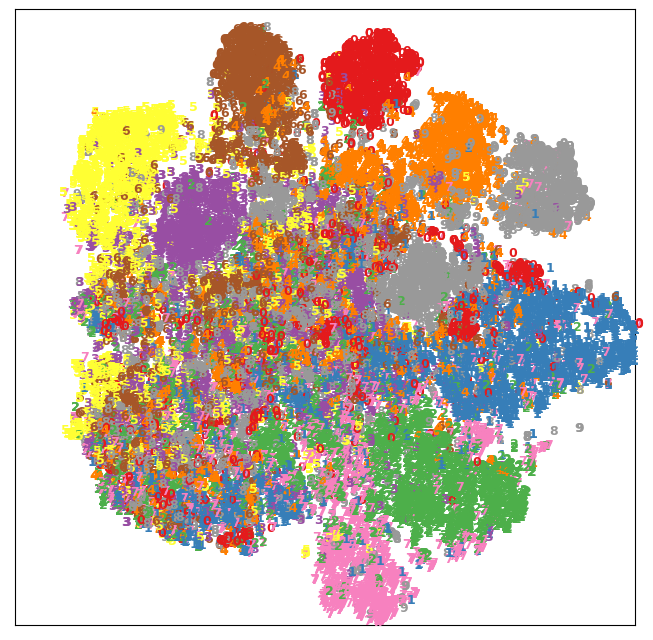

In [14]:
tsne_norm = tsne_by_label(all_feat, all_label)

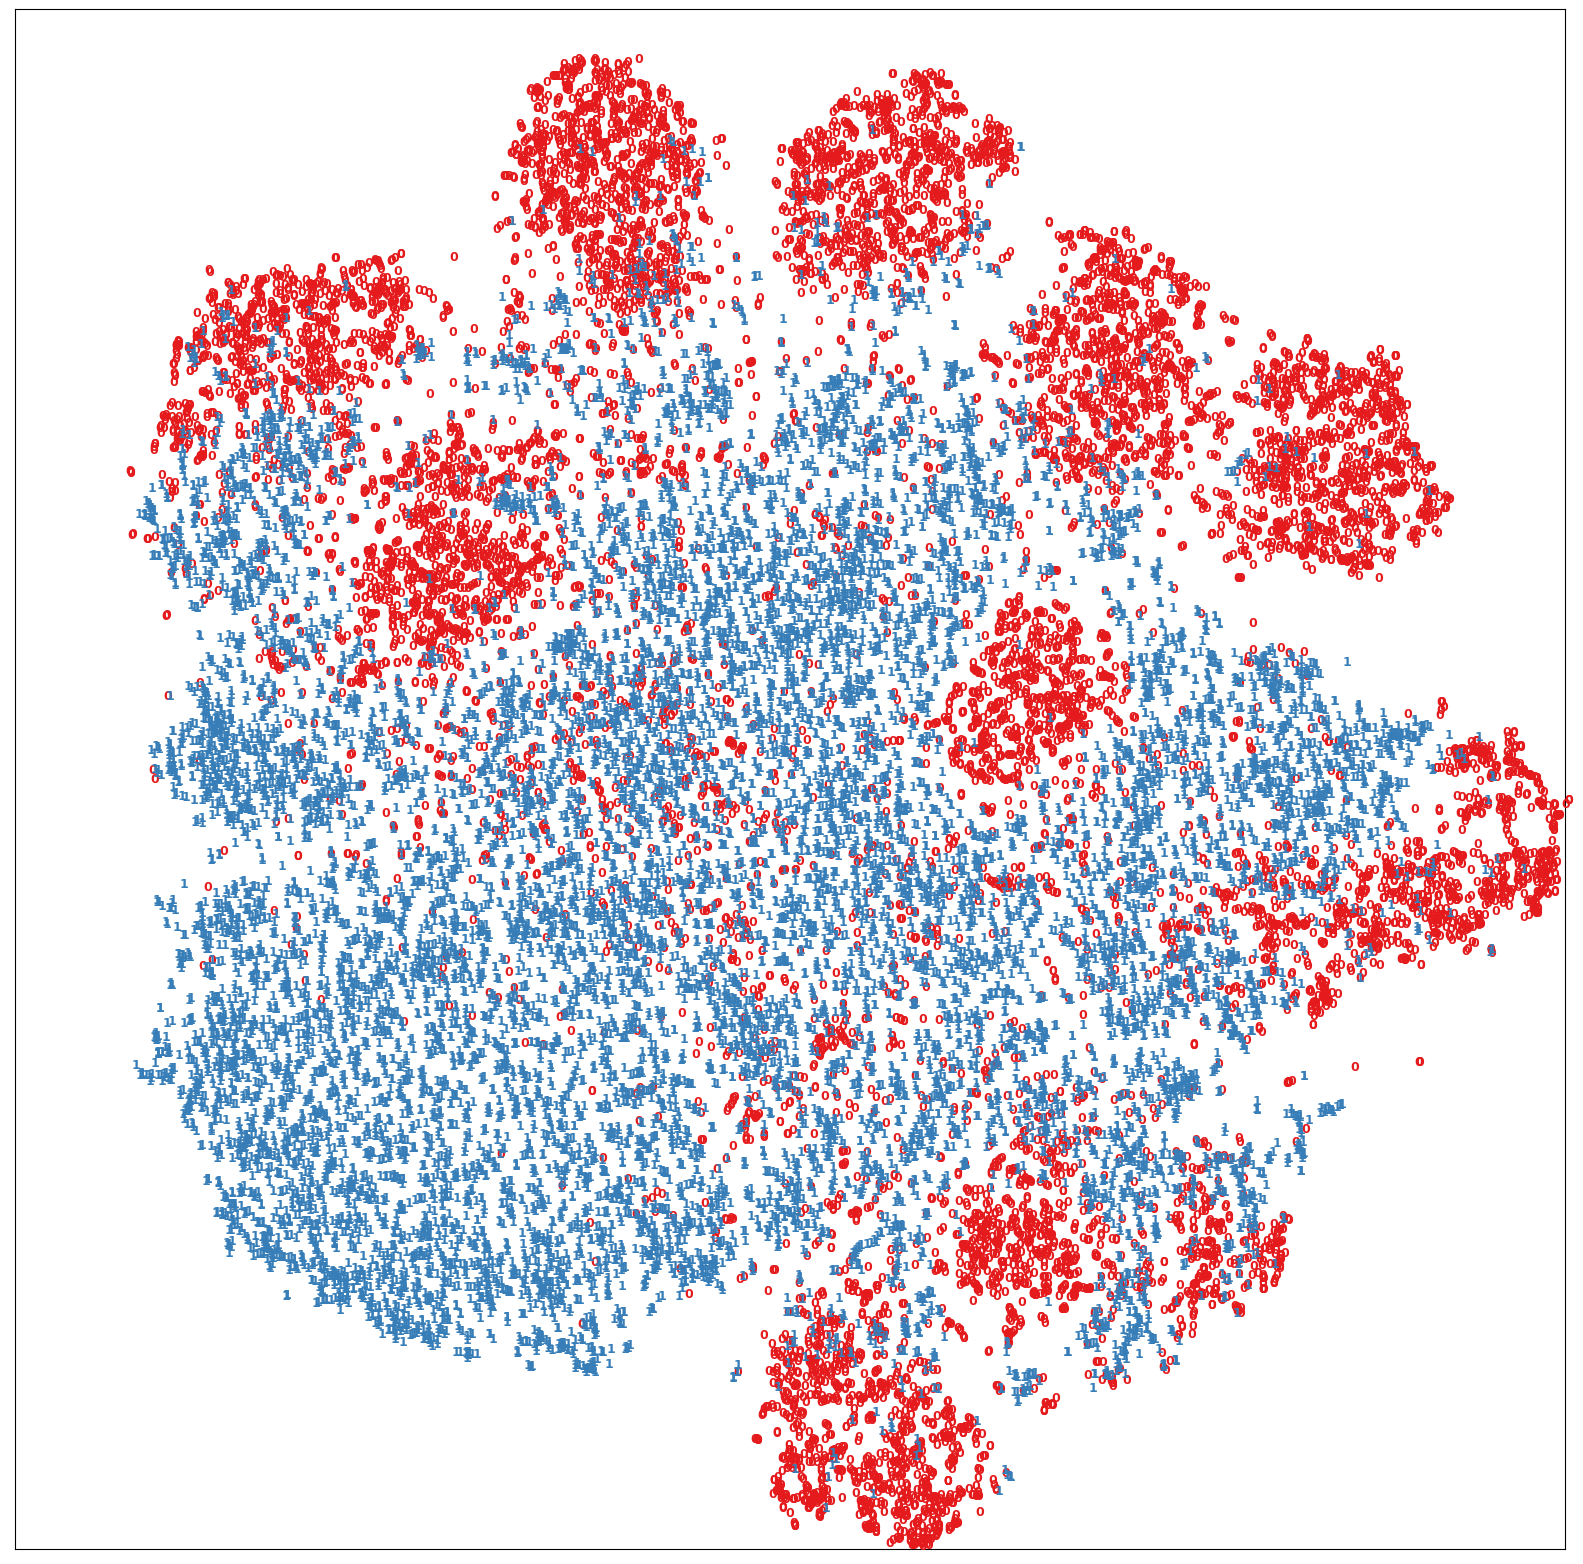

In [15]:
# source: 0
# target: 1
all_label = np.concatenate(
    [np.zeros(mnistm_feat.shape[0], dtype=int), np.ones(svhn_feat.shape[0], dtype=int)],
    axis = 0
)
tsne_by_domain(tsne_norm, all_label)

## usps

In [16]:
model = DANN(args.use_dann, args.get_feat).to(device)
model_path = 'p3_usps.ckpt'
ckpt = torch.load(model_path)
model.load_state_dict(ckpt['model'])

<All keys matched successfully>

In [17]:
mnistm_feat, mnistm_label = get_feat_n_label(model, mnistm_dl)
usps_feat, usps_label = get_feat_n_label(model, usps_dl)

In [18]:
print(mnistm_feat.shape, mnistm_label.shape)
print(usps_feat.shape, usps_label.shape)

(11200, 1152) (11200,)
(1488, 1152) (1488,)


/home/guest/r11922a05/anaconda3/envs/dlcv-hw2/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/guest/r11922a05/anaconda3/envs/dlcv-hw2/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


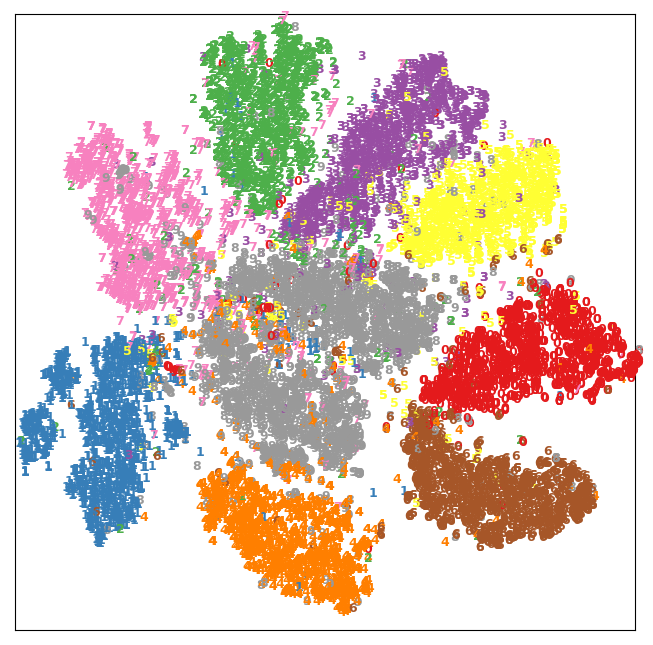

In [19]:
all_feat = np.concatenate([mnistm_feat, usps_feat], axis = 0)
all_label = np.concatenate([mnistm_label, usps_label], axis = 0)
tsne_norm = tsne_by_label(all_feat, all_label)

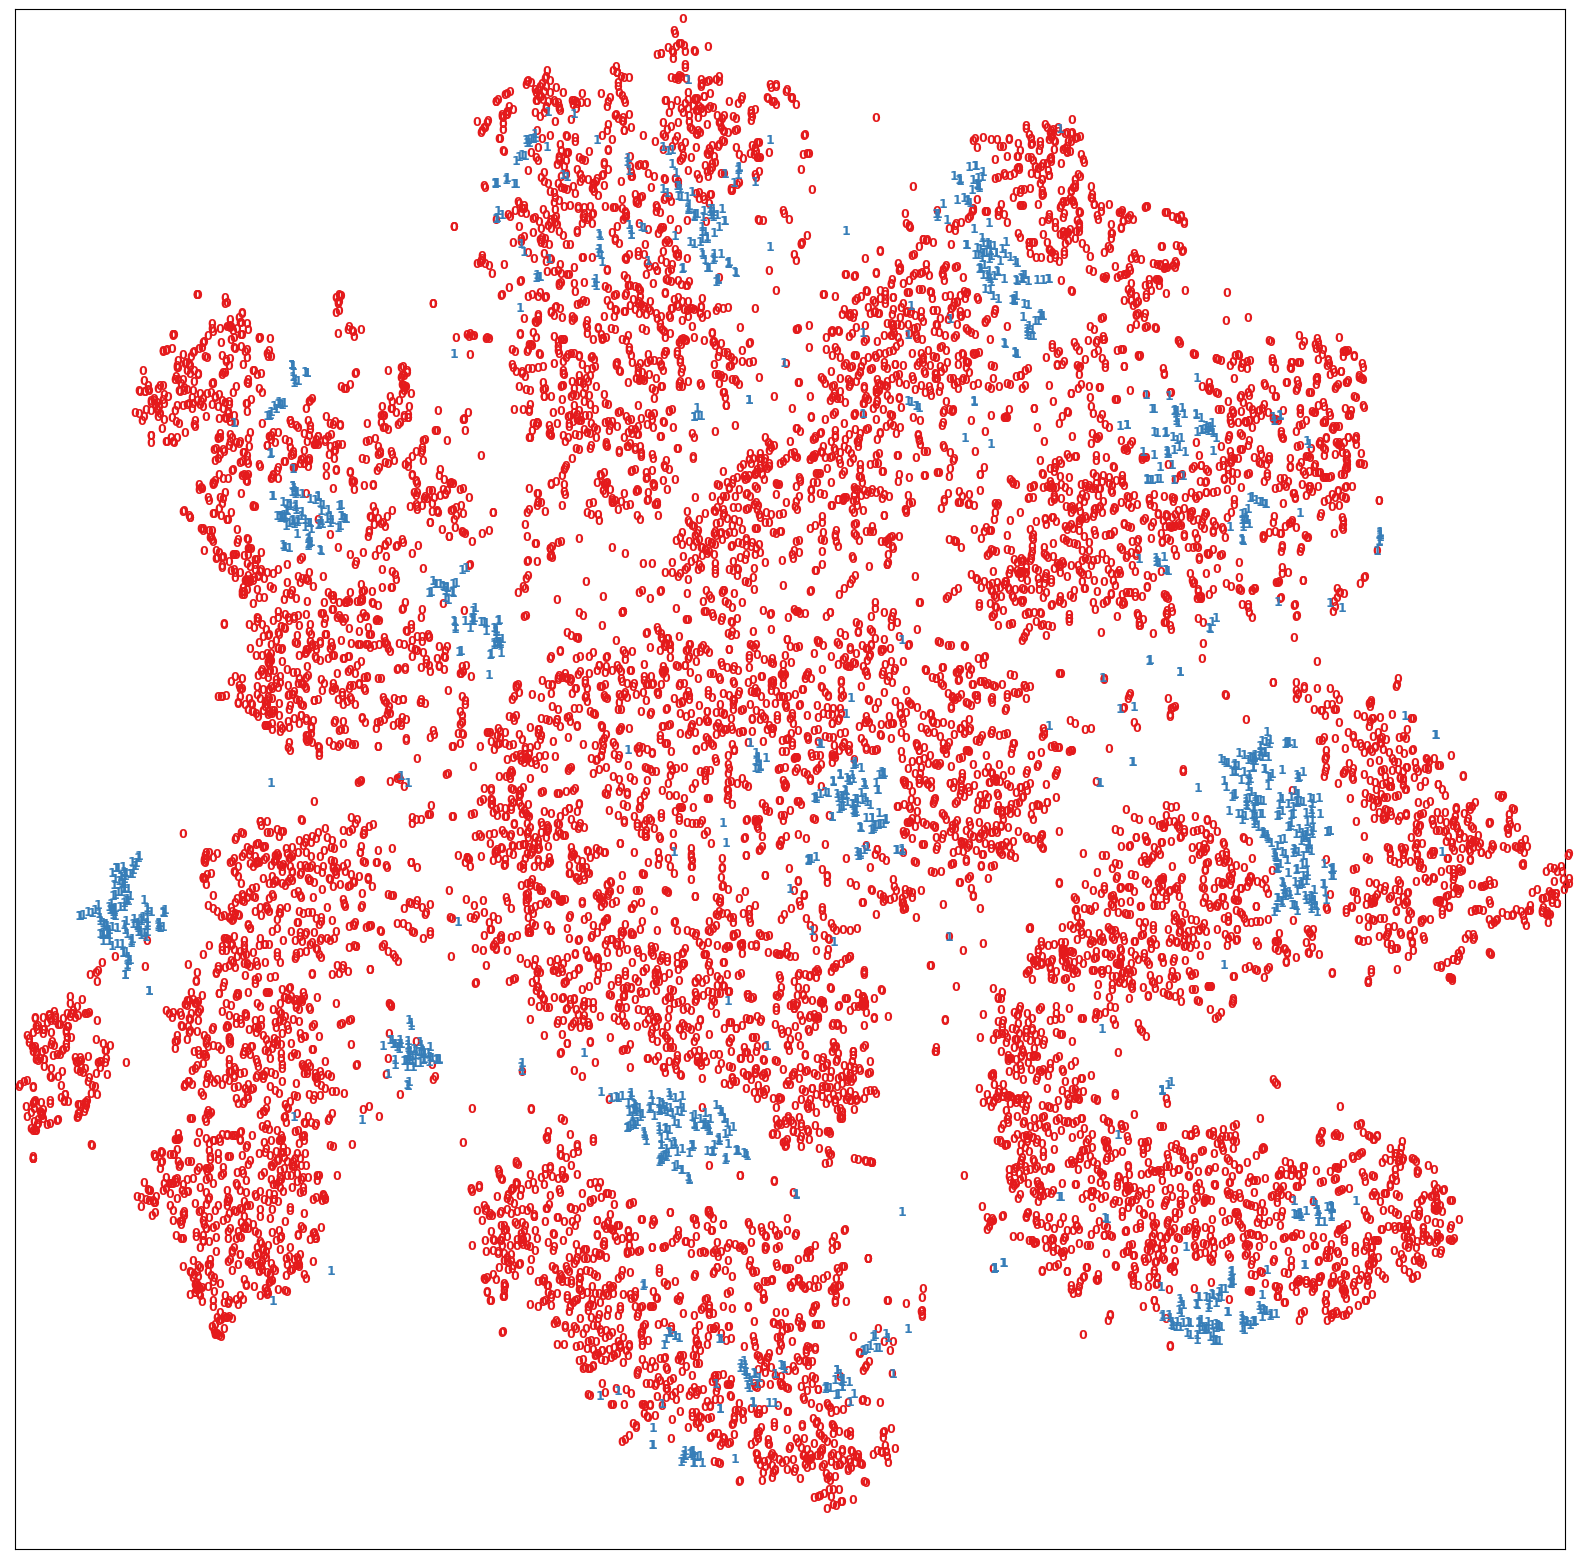

In [20]:
# source: 0
# target: 1
all_label = np.concatenate(
    [np.zeros(mnistm_feat.shape[0], dtype=int), np.ones(usps_feat.shape[0], dtype=int)],
    axis = 0
)
tsne_by_domain(tsne_norm, all_label)